In [1]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

import BlockNNClustering
reload(BlockNNClustering)
from BlockNNClustering import *

In [2]:
# Class for saving cluster information 
# of a single agent selection
@dataclass
class Clusters:
    n: int
    n_noise: int
    mean_size: float
    std_size: float
    unique_labels: np.ndarray
    counts: np.ndarray
    
    @staticmethod
    def build(labels):
        unique_labels_, counts_ = np.unique(labels, return_counts=True)
        n_ = unique_labels_[unique_labels_ >= 0].size
        noise_counts = counts_[unique_labels_ == -1]
        n_noise_ = noise_counts[0] if noise_counts.size > 0 else 0
        mean_size_ = counts_[unique_labels_ >= 0].mean()
        std_size_ = counts_[unique_labels_ >= 0].std()

        return Clusters(    
            n_, n_noise_, mean_size_, std_size_, 
            unique_labels_, counts_
        )
    
    def tolist(self): # includes noise
        size_list = self.counts[self.unique_labels >= 0].tolist()
        size_list.extend([1 for _ in range(self.n_noise)])
        return size_list
    
# Class for saving cluster information
# of a single state
@dataclass
class StateClusters:
    positive: Clusters
    negative: Clusters
        
    @staticmethod
    def build(all_labels):
        labels_pos_, labels_neg_ = all_labels
        pos_ = Clusters.build(labels_pos_)
        neg_ = Clusters.build(labels_neg_)
        return StateClusters(pos_, neg_)
    
@dataclass
class StateClusterStats:
    positive: list
    negative: list
    seeds: list
    
    @staticmethod
    def create():
        return StateClusterStats([], [], [])
    
    def add(self, state_clusters, seed):
        self.positive.append(state_clusters.positive)
        self.negative.append(state_clusters.negative)
        self.seeds.append(seed)
        
    def n(self, filtered=""):
        if filtered == "positive":
            return np.array([p_.n for p_ in self.positive])
        elif filtered == "negative":
            return np.array([n_.n for n_ in self.negative])
        else:
            return np.array(
                [c.n for c in self.positive]
                            .extend([n_.n for n_ in self.negative])
            )

In [3]:
# load data from and create cluster analysis
# files contain data in dataframe format
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]

# save data together with distribution
@dataclass
class StateAnalysis:
    stats: StateClusterStats
    distribution: object
        
    @staticmethod
    def create(distribution):
        return StateAnalysis(StateClusterStats.create(), distribution)


def add_final_state_clusters_from_file(results, file, distribution, final_step=1000):
    
    if not os.path.exists(file):
        print("File %s not found." % file)
        return
    
    data_ = LoadSimulation(file, columns=columns)   
    n_select = 3
    seeds_ = np.random.choice(data_.get("seed").unique(), size=n_select)

    # init cluster props
    analysis = StateAnalysis.create(distribution)
    block_clustering = BlockNNClustering(min_cluster_size=1)
    
    for j, seed in enumerate(seeds_):
        sample = data_.query("seed == @seed")
        grid_data = Grid(Choice(sample, final_step))
        decisions = np.int32(grid_data >= 0.5)
        _, all_labels = block_clustering.fit(decisions)
        analysis.stats.add(StateClusters.build(all_labels), seed)
        
    results.append(analysis)
    

In [4]:
beta_dist_path = "../data/distributions/beta/"

def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

@dataclass
class BetaPdf:
    # definition see WIKI
    mean: float
    alpha: float
    beta: float

def GetBetaPdfFromFileName(fname):
    a = float(find_between(fname, "a-", "_"))
    b = float(find_between(fname, "b-", "_"))
    m = float(find_between(fname, "m-", ".csv"))
    return BetaPdf(m, a, b)
        
beta_files = []
for file in os.listdir(beta_dist_path):
    betaPdf = GetBetaPdfFromFileName(file)
    if "agent_data" in file:
        beta_files.append((file, betaPdf))

In [5]:
beta_clusters = []

In [6]:
const_clusters = []

In [7]:
ExistsBeta = lambda x, arr: (x.mean, x.alpha, x.beta) in [(a.mean, a.alpha, a.beta) \
                                                          for a in arr if type(a) == BetaPdf]
for file, beta_dist in beta_files[:]:
    print(f"Build cluster analysis for distribution {beta_dist}")
    path = os.path.join(beta_dist_path, file)
    if not ExistsBeta(beta_dist, [x_.distribution for x_ in beta_clusters]):
        add_final_state_clusters_from_file(beta_clusters, path, beta_dist, final_step=100)

Build cluster analysis for distribution BetaPdf(mean=0.5, alpha=1.2, beta=1.2)
Build cluster analysis for distribution BetaPdf(mean=0.45, alpha=1.2, beta=1.47)
Build cluster analysis for distribution BetaPdf(mean=0.4, alpha=1.2, beta=1.8)
Build cluster analysis for distribution BetaPdf(mean=0.1, alpha=1.2, beta=10.8)
Build cluster analysis for distribution BetaPdf(mean=0.35, alpha=1.2, beta=2.23)
Build cluster analysis for distribution BetaPdf(mean=0.3, alpha=1.2, beta=2.8)
Build cluster analysis for distribution BetaPdf(mean=0.05, alpha=1.2, beta=22.8)
Build cluster analysis for distribution BetaPdf(mean=0.25, alpha=1.2, beta=3.6)
Build cluster analysis for distribution BetaPdf(mean=0.2, alpha=1.2, beta=4.8)
Build cluster analysis for distribution BetaPdf(mean=0.15, alpha=1.2, beta=6.8)
Build cluster analysis for distribution BetaPdf(mean=0.55, alpha=1.47, beta=1.2)
Build cluster analysis for distribution BetaPdf(mean=0.6, alpha=1.8, beta=1.2)
Build cluster analysis for distribution B

In [8]:
def add_final_state_clusters_const_from_file(results, location, distribution, final_step=800):
    columns_ = ["step", "id", "avantgarde", "affinity", "affinityGoal"]
    
    # init cluster props
    analysis = StateAnalysis.create(distribution)
    block_clustering = BlockNNClustering(min_cluster_size=1)

    keys = np.array([*range(1, 24)])
    for j, key in enumerate(np.random.choice(keys, size=15)):
        file = f"agent_data_800steps_{key:d}.csv"
        path = os.path.join(location, file)
        
        if not os.path.exists(path):
            print("File %s not found." % path)
            continue
        
        data = LoadSimulation(path, columns=columns_)
        sample = data.query("avantgarde == @distribution.value")
        grid_data = Grid(Choice(sample, final_step))
        decisions = np.int32(grid_data >= 0.5)
        _, all_labels = block_clustering.fit(decisions)
        analysis.stats.add(StateClusters.build(all_labels), 100 + key)
        
    results.append(analysis)
    

@dataclass
class ConstantPdf:
    value: float # all samples have same value

        
path = "../data/constant_avantgarde/"
for a in np.arange(0.05, 1.0, 0.05)[:]:
    const_dist = ConstantPdf(np.round(a, 2))
    print(f"Build cluster analysis for distribution {const_dist}")
    if not const_dist.value in [x_.distribution.value for x_ in const_clusters]:
        add_final_state_clusters_const_from_file(const_clusters, path, const_dist)

Build cluster analysis for distribution ConstantPdf(value=0.05)
Build cluster analysis for distribution ConstantPdf(value=0.1)
Build cluster analysis for distribution ConstantPdf(value=0.15)
Build cluster analysis for distribution ConstantPdf(value=0.2)
Build cluster analysis for distribution ConstantPdf(value=0.25)
Build cluster analysis for distribution ConstantPdf(value=0.3)
Build cluster analysis for distribution ConstantPdf(value=0.35)
Build cluster analysis for distribution ConstantPdf(value=0.4)
Build cluster analysis for distribution ConstantPdf(value=0.45)
Build cluster analysis for distribution ConstantPdf(value=0.5)
Build cluster analysis for distribution ConstantPdf(value=0.55)
Build cluster analysis for distribution ConstantPdf(value=0.6)
Build cluster analysis for distribution ConstantPdf(value=0.65)
Build cluster analysis for distribution ConstantPdf(value=0.7)
Build cluster analysis for distribution ConstantPdf(value=0.75)
Build cluster analysis for distribution Constan

In [9]:
@dataclass
class StateCD:
    satisfaction: np.ndarray
    cognitive_dissonance: np.ndarray
    distribution: object

In [10]:
# estimate satisfaction
def estimate_satisfaction_from_const_file(results, location, distribution, final_step=800):
    columns_ = ["step", "id", "avantgarde", "affinity", "affinityGoal"]
    
    # init cluster props
    state_cd = StateCD(np.empty(0), np.empty(0), distribution)

    keys = np.array([*range(1, 24)])
    for j, key in enumerate(np.random.choice(keys, size=15)):
        file = f"agent_data_800steps_{key:d}.csv"
        path = os.path.join(location, file)
        
        if not os.path.exists(path):
            print("File %s not found." % path)
            continue
        
        data = LoadSimulation(path, columns=columns_)
        sample = data.query("avantgarde == @distribution.value")
        choice = Choice(sample, final_step)
        belief = Belief(sample, final_step)
        decisions = np.int32(choice >= 0.5)
        intrinsic_decisions = np.int32(belief >= 0.5)
        
        s = np.sum(decisions == intrinsic_decisions)
        cd = np.mean(np.abs(choice - belief))
        
        state_cd.satisfaction = np.append(state_cd.satisfaction, s)
        state_cd.cognitive_dissonance = np.append(state_cd.cognitive_dissonance, cd)
        
    results.append(state_cd)

const_satisfaction = []

path = "../data/constant_avantgarde/"
for a in np.arange(0.05, 1.0, 0.05)[:]:
    const_dist = ConstantPdf(np.round(a, 2))
    print(f"Build satisfaction analysis for distribution {const_dist}")
    if not const_dist.value in [x_.distribution.value for x_ in const_satisfaction]:
        estimate_satisfaction_from_const_file(const_satisfaction, path, const_dist)

Build satisfaction analysis for distribution ConstantPdf(value=0.05)
Build satisfaction analysis for distribution ConstantPdf(value=0.1)
Build satisfaction analysis for distribution ConstantPdf(value=0.15)
Build satisfaction analysis for distribution ConstantPdf(value=0.2)
Build satisfaction analysis for distribution ConstantPdf(value=0.25)
Build satisfaction analysis for distribution ConstantPdf(value=0.3)
Build satisfaction analysis for distribution ConstantPdf(value=0.35)
Build satisfaction analysis for distribution ConstantPdf(value=0.4)
Build satisfaction analysis for distribution ConstantPdf(value=0.45)
Build satisfaction analysis for distribution ConstantPdf(value=0.5)
Build satisfaction analysis for distribution ConstantPdf(value=0.55)
Build satisfaction analysis for distribution ConstantPdf(value=0.6)
Build satisfaction analysis for distribution ConstantPdf(value=0.65)
Build satisfaction analysis for distribution ConstantPdf(value=0.7)
Build satisfaction analysis for distribut

In [11]:
# estimate satisfaction
def estimate_satisfaction_from_file(results, file, distribution, final_step=800):
    if not os.path.exists(file):
        print("File %s not found." % file)
        return
    
    state_cd = StateCD(np.empty(0), np.empty(0), distribution)
    data_ = LoadSimulation(file, columns=columns)   
    n_select = 3
    seeds_ = np.random.choice(data_.get("seed").unique(), size=n_select)
    
    for j, seed in enumerate(seeds_):
        sample = data_.query("seed == @seed")
        
        choice = Choice(sample, final_step)
        belief = Belief(sample, final_step)
        decisions = np.int32(choice >= 0.5)
        intrinsic_decisions = np.int32(belief >= 0.5)
        
        s = np.sum(decisions == intrinsic_decisions)
        cd = np.mean(np.abs(choice - belief))
        
        state_cd.satisfaction = np.append(state_cd.satisfaction, s)
        state_cd.cognitive_dissonance = np.append(state_cd.cognitive_dissonance, cd)
        
    results.append(state_cd)

beta_satisfaction = []

ExistsBeta = lambda x, arr: (x.mean, x.alpha, x.beta) in [(a.mean, a.alpha, a.beta) \
                                                          for a in arr if type(a) == BetaPdf]
for file, beta_dist in beta_files[:]:
    print(f"Build satisfaction analysis for distribution {beta_dist}")
    path = os.path.join(beta_dist_path, file)
    if not ExistsBeta(beta_dist, [x_.distribution for x_ in beta_satisfaction]):
        estimate_satisfaction_from_file(beta_satisfaction, path, beta_dist, final_step=100)

Build satisfaction analysis for distribution BetaPdf(mean=0.5, alpha=1.2, beta=1.2)
Build satisfaction analysis for distribution BetaPdf(mean=0.45, alpha=1.2, beta=1.47)
Build satisfaction analysis for distribution BetaPdf(mean=0.4, alpha=1.2, beta=1.8)
Build satisfaction analysis for distribution BetaPdf(mean=0.1, alpha=1.2, beta=10.8)
Build satisfaction analysis for distribution BetaPdf(mean=0.35, alpha=1.2, beta=2.23)
Build satisfaction analysis for distribution BetaPdf(mean=0.3, alpha=1.2, beta=2.8)
Build satisfaction analysis for distribution BetaPdf(mean=0.05, alpha=1.2, beta=22.8)
Build satisfaction analysis for distribution BetaPdf(mean=0.25, alpha=1.2, beta=3.6)
Build satisfaction analysis for distribution BetaPdf(mean=0.2, alpha=1.2, beta=4.8)
Build satisfaction analysis for distribution BetaPdf(mean=0.15, alpha=1.2, beta=6.8)
Build satisfaction analysis for distribution BetaPdf(mean=0.55, alpha=1.47, beta=1.2)
Build satisfaction analysis for distribution BetaPdf(mean=0.6, al

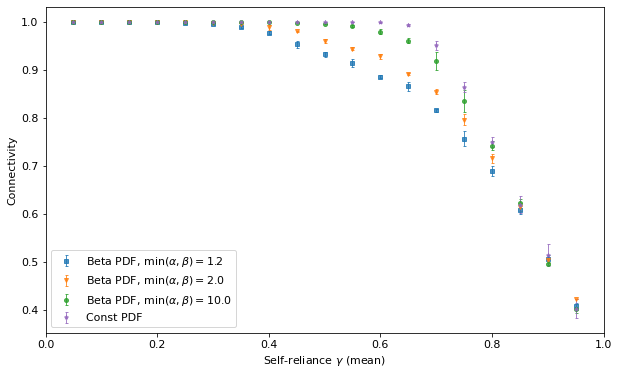

In [12]:
import matplotlib.pyplot as plt

# Plot connectivity
def Connectivity(counts):
    counts = np.array(counts)
    s = counts.sum()
    return (s - counts.size) / (s - 1)


plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 11, "figure.dpi": 147})

# plot beta
min_alpha_beta = (1.2, 2.0, 10.0)
colors = ("tab:blue", "tab:orange", "tab:green",)
markers = ("s", "v", "o", "*", )
for value, color, marker in zip(min_alpha_beta, colors, markers):
    
    filtered_ = list(
        filter(lambda x_: min(x_.distribution.alpha, x_.distribution.beta) == value, beta_clusters)
    )

    x = [x_.distribution.mean for x_ in filtered_]
    #y = [np.mean([c_.n for c_ in x_.stats.positive])  for x_ in filtered_]
    #yerr = [np.std([c_.n for c_ in x_.stats.positive])  for x_ in filtered_]
    
    y = [np.mean([Connectivity(c_.tolist()) for c_ in x_.stats.positive])  for x_ in filtered_]
    yerr = [np.std([Connectivity(c_.tolist()) for c_ in x_.stats.positive])  for x_ in filtered_]
    
    variance_at05 = 1./(2 * (2 * value + 1))
    label = f"Beta PDF, " + fr"$\min(\alpha, \beta)={value:.1f}$"
    
    plt.errorbar(x, y, yerr=yerr, c=color, alpha=0.8, label=label, 
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5)


# plot const
x = [x_.distribution.value for x_ in const_clusters]
y = [np.mean([Connectivity(c_.tolist()) for c_ in x_.stats.positive]) for x_ in const_clusters]
yerr = [np.std([Connectivity(c_.tolist()) for c_ in x_.stats.positive]) for x_ in const_clusters]
label = f"Const PDF"
plt.errorbar(x, y, yerr=yerr, c="tab:purple", alpha=0.8, label=label, 
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5)

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.xlabel(r"Self-reliance $\gamma}$ (mean)")
plt.ylabel("Connectivity")

plt.show()

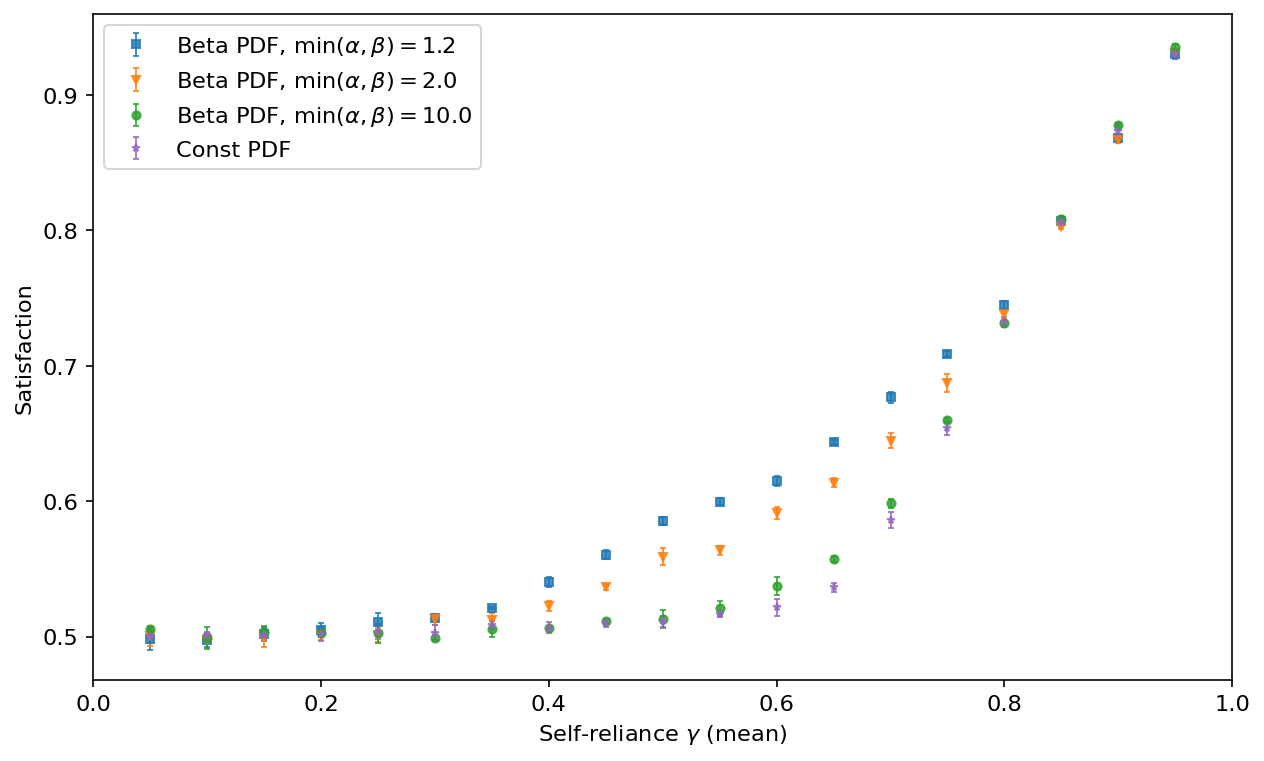

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 11, "figure.dpi": 147})

# plot beta
min_alpha_beta = (1.2, 2.0, 10.0)
colors = ("tab:blue", "tab:orange", "tab:green",)
markers = ("s", "v", "o", "*", )
for value, color, marker in zip(min_alpha_beta, colors, markers):
    
    filtered_ = list(
        filter(lambda x_: min(x_.distribution.alpha, x_.distribution.beta) == value, beta_satisfaction)
    )

    x = [x_.distribution.mean for x_ in filtered_]
    y = [x_.satisfaction.mean() / 10000 for x_ in filtered_]
    yerr = [x_.satisfaction.std() / 10000 for x_ in filtered_]
    
    variance_at05 = 1./(2 * (2 * value + 1))
    label = f"Beta PDF, " + fr"$\min(\alpha, \beta)={value:.1f}$"
    
    plt.errorbar(x, y, yerr=yerr, c=color, alpha=0.8, label=label, 
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5)

# plot const
x = [x_.distribution.value for x_ in const_satisfaction]
y = [x_.satisfaction.mean() / 10000 for x_ in const_satisfaction]
yerr = [x_.satisfaction.std() / 10000 for x_ in const_satisfaction]
label = f"Const PDF"
plt.errorbar(x, y, yerr=yerr, c="tab:purple", alpha=0.8, label=label, 
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5)

plt.xlim([0, 1])
plt.legend(loc="upper left")
plt.xlabel(r"Self-reliance $\gamma}$ (mean)")
plt.ylabel("Satisfaction")

plt.show()

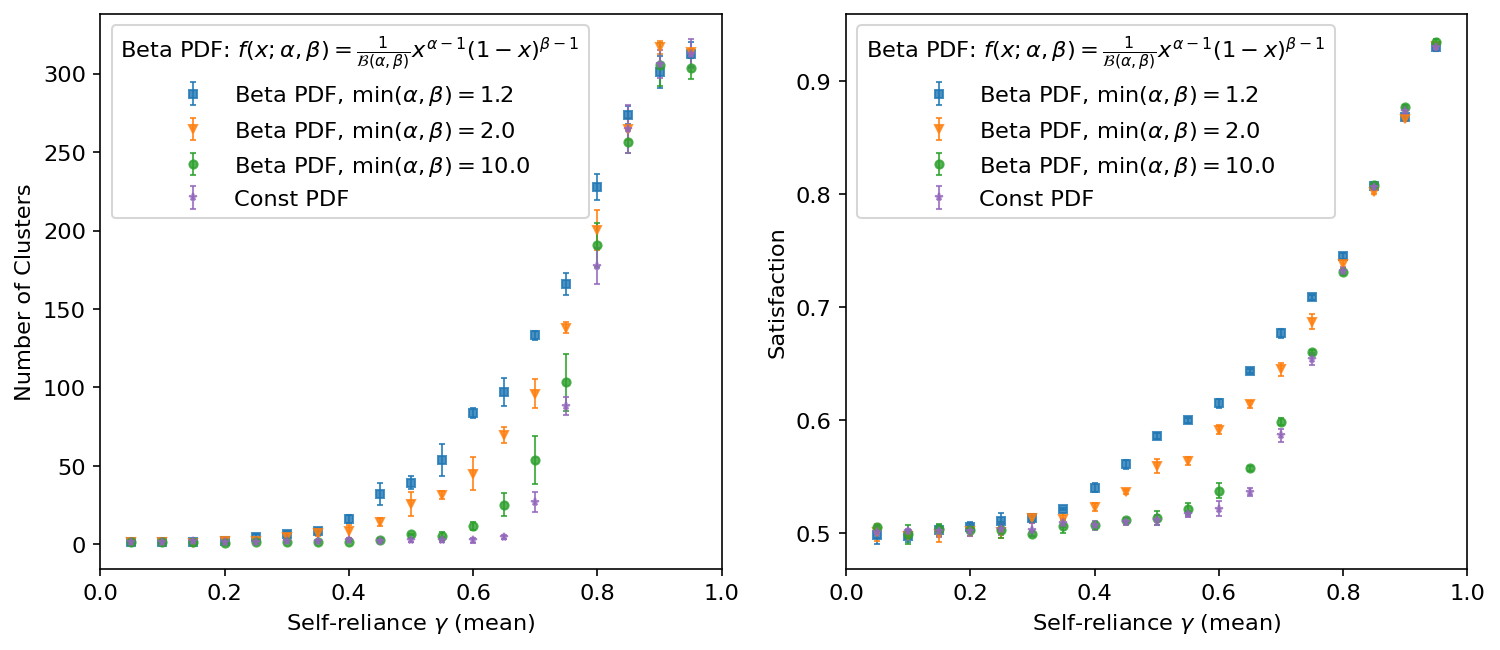

In [14]:
import matplotlib.pyplot as plt

# Plot connectivity
def Connectivity(counts):
    counts = np.array(counts)
    s = counts.sum()
    return (s - counts.size) / (s - 1)


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams.update({'font.size': 11, "figure.dpi": 147})

# plot beta
min_alpha_beta = (1.2, 2.0, 10.0)
colors = ("tab:blue", "tab:orange", "tab:green",)
markers = ("s", "v", "o", "*", )
for value, color, marker in zip(min_alpha_beta, colors, markers):
    
    filtered_ = list(
        filter(lambda x_: min(x_.distribution.alpha, x_.distribution.beta) == value, beta_clusters)
    )

    x = [x_.distribution.mean for x_ in filtered_]
    y = [np.mean([c_.n for c_ in x_.stats.positive])  for x_ in filtered_]
    yerr = [np.std([c_.n for c_ in x_.stats.positive])  for x_ in filtered_]
    
    #y = [np.mean([Connectivity(c_.tolist()) for c_ in x_.stats.positive])  for x_ in filtered_]
    #yerr = [np.std([Connectivity(c_.tolist()) for c_ in x_.stats.positive])  for x_ in filtered_]
    
    variance_at05 = 1./(2 * (2 * value + 1))
    label = f"Beta PDF, " + fr"$\min(\alpha, \beta)={value:.1f}$"
    
    ax0.errorbar(x, y, yerr=yerr, c=color, alpha=0.8, label=label, 
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5)
    
    filtered_ = list(
        filter(lambda x_: min(x_.distribution.alpha, x_.distribution.beta) == value, beta_satisfaction)
    )

    x = [x_.distribution.mean for x_ in filtered_]
    y = [x_.satisfaction.mean() / 10000 for x_ in filtered_]
    yerr = [x_.satisfaction.std() / 10000 for x_ in filtered_]
    
    variance_at05 = 1./(2 * (2 * value + 1))
    label = f"Beta PDF, " + fr"$\min(\alpha, \beta)={value:.1f}$"
    
    ax1.errorbar(x, y, yerr=yerr, c=color, alpha=0.8, label=label, 
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5)


# plot const
x = [x_.distribution.value for x_ in const_clusters]
#y = [np.mean([Connectivity(c_.tolist()) for c_ in x_.stats.positive]) for x_ in const_clusters]
#yerr = [np.std([Connectivity(c_.tolist()) for c_ in x_.stats.positive]) for x_ in const_clusters]

y = [np.mean([c_.n for c_ in x_.stats.positive]) for x_ in const_clusters]
yerr = [np.std([c_.n for c_ in x_.stats.positive]) for x_ in const_clusters]
label = f"Const PDF"
ax0.errorbar(x, y, yerr=yerr, c="tab:purple", alpha=0.8, label=label, 
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5)

ax0.set_xlim([0, 1])
ax0.legend(loc="upper left", title=r"Beta PDF: $f(x;\alpha, \beta)=\frac{1}{\mathcal{B}(\alpha, \beta)}x^{\alpha-1} (1-x)^{\beta-1}$")
ax0.set_xlabel(r"Self-reliance $\gamma}$ (mean)")
ax0.set_ylabel("Number of Clusters")

# plot const
x = [x_.distribution.value for x_ in const_satisfaction]
y = [x_.satisfaction.mean() / 10000 for x_ in const_satisfaction]
yerr = [x_.satisfaction.std() / 10000 for x_ in const_satisfaction]
label = f"Const PDF"
ax1.errorbar(x, y, yerr=yerr, c="tab:purple", alpha=0.8, label=label, 
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5)

ax1.set_xlim([0, 1])
ax1.legend(loc="upper left", title=r"Beta PDF: $f(x;\alpha, \beta)=\frac{1}{\mathcal{B}(\alpha, \beta)}x^{\alpha-1} (1-x)^{\beta-1}$")
ax1.set_xlabel(r"Self-reliance $\gamma}$ (mean)")
ax1.set_ylabel("Satisfaction")

plt.show()